<a href="https://colab.research.google.com/github/mpiatek26/Predicting_the_likelihood_of_e-signing_a_loan_based_on_financial_history/blob/main/Predicting_the_likelihood_of_e_signing_a_loan_based_on_financial_history_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import random
import time

random.seed(100)

In [8]:
### Data Preprocessing ###

dataset = pd.read_csv('P39-Financial-Data.csv')

In [9]:
# Feature Engineering

dataset = dataset.drop(columns = ['months_employed'])
dataset['personal_account_months'] = (dataset.personal_account_m + (dataset.personal_account_y * 12))
dataset[['personal_account_m', 'personal_account_y', 'personal_account_months']].head()
dataset = dataset.drop(columns = ['personal_account_m', 'personal_account_y'])

In [10]:
# One Hot Encoding
dataset = pd.get_dummies(dataset)
dataset.columns
dataset = dataset.drop(columns = ['pay_schedule_semi-monthly'])

In [11]:
# Removing extra columns
response = dataset["e_signed"]
users = dataset['entry_id']
dataset = dataset.drop(columns = ["e_signed", "entry_id"])

In [12]:
# Splitting into Train and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset,
                                                    response,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [13]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [15]:
#### Model Building ####

### Comparing Models

## Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, penalty = 'l1', solver='saga')
classifier.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=0, solver='saga')

In [16]:
# Predicting Test Set
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [17]:
results = pd.DataFrame([['Linear Regression (Lasso)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [18]:
## SVM (Linear)
from sklearn.svm import SVC
classifier = SVC(random_state = 0, kernel = 'linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [19]:
# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [20]:
model_results = pd.DataFrame([['SVM (Linear)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [21]:
results = results.append(model_results, ignore_index = True)

<ipython-input-21-94dcc59cdd10>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [22]:
## SVM (rbf)
from sklearn.svm import SVC
classifier = SVC(random_state = 0, kernel = 'rbf')
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [23]:
# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [24]:
model_results = pd.DataFrame([['SVM (RBF)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [25]:
results = results.append(model_results, ignore_index = True)

<ipython-input-25-94dcc59cdd10>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [26]:
## SVM (rbf)
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 0, n_estimators = 100,
                                    criterion = 'entropy')
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [27]:
# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [28]:
model_results = pd.DataFrame([['Random Forest (n=100)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [29]:
results = results.append(model_results, ignore_index = True)

<ipython-input-29-94dcc59cdd10>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [30]:
## K-fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X= X_train, y = y_train,
                             cv = 10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Random Forest Classifier Accuracy: 0.63 (+/- 0.03)


In [32]:
### Parameter Tuning
!pip install joblib
!conda install joblib

/bin/bash: line 1: conda: command not found


In [33]:
# Applying Grid Search

# Round 1: Entropy
parameters = {"max_depth": [3, None],
              "max_features": [1, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10],
              "bootstrap": [True, False],
              "criterion": ["entropy"]}

In [34]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = classifier, # Make sure classifier points to the RF model
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)

t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

Took 4539.09 seconds


In [36]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_

In [37]:
rf_best_accuracy

0.6345122647725013

In [39]:
rf_best_parameters

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [40]:
# Round 2: Entropy
parameters = {"max_depth": [None],
              "max_features": [3, 5, 7],
              'min_samples_split': [8, 10, 12],
              'min_samples_leaf': [1, 2, 3],
              "bootstrap": [True],
              "criterion": ["entropy"]}

In [41]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = classifier, # Make sure classifier points to the RF model
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 4,
                           n_jobs = -1)

In [42]:
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

Took 505.32 seconds


In [44]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_

In [45]:
rf_best_accuracy

0.6298339100011522

In [46]:
rf_best_parameters

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 8}

In [47]:
# Predicting Test Set
y_pred = grid_search.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [48]:
model_results = pd.DataFrame([['Random Forest (n=100, GSx2 + Entropy)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [49]:
results = results.append(model_results, ignore_index = True)

<ipython-input-49-94dcc59cdd10>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [50]:
# Round 1: Gini
parameters = {"max_depth": [3, None],
              "max_features": [1, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10],
              "bootstrap": [True, False],
              "criterion": ["gini"]}

In [51]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = classifier, # Make sure classifier points to the RF model
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 4,
                           n_jobs = -1)

In [52]:
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

Took 1104.71 seconds


In [53]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_

(0.632207763038719,
 {'bootstrap': True,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': 10,
  'min_samples_leaf': 5,
  'min_samples_split': 2})

In [54]:
rf_best_accuracy

0.632207763038719

In [55]:
rf_best_parameters

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [56]:
# Round 2: Gini
parameters = {"max_depth": [None],
              "max_features": [8, 10, 12],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [8, 10, 12],
              "bootstrap": [True],
              "criterion": ["gini"]}

In [57]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = classifier, # Make sure classifier points to the RF model
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 4,
                           n_jobs = -1)

In [58]:
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

Took 591.53 seconds


In [59]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_

In [60]:
rf_best_accuracy

0.6315102577019884

In [61]:
 rf_best_parameters

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [63]:
# Predicting Test Set
y_pred = grid_search.predict(X_test)

In [64]:
acc = accuracy_score(y_test, y_pred)

In [65]:
prec = precision_score(y_test, y_pred)

In [66]:
rec = recall_score(y_test, y_pred)

In [67]:
f1 = f1_score(y_test, y_pred)

In [68]:
model_results = pd.DataFrame([['Random Forest (n=100, GSx2 + Gini)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [69]:
results = results.append(model_results, ignore_index = True)

<ipython-input-69-94dcc59cdd10>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [70]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Linear Regression (Lasso),0.562814,0.576500,0.707469,0.635305
1,SVM (Linear),0.568398,0.577832,0.735477,0.647193
2,SVM (RBF),0.591569,0.605730,0.690871,0.645505
3,Random Forest (n=100),0.621720,0.640098,0.678942,0.658948
4,"Random Forest (n=100, GSx2 + Entropy)",0.633445,0.649490,0.692946,0.670514
5,"Random Forest (n=100, GSx2 + Gini)",0.633166,0.647031,0.700726,0.672809


Test Data Accuracy: 0.6332


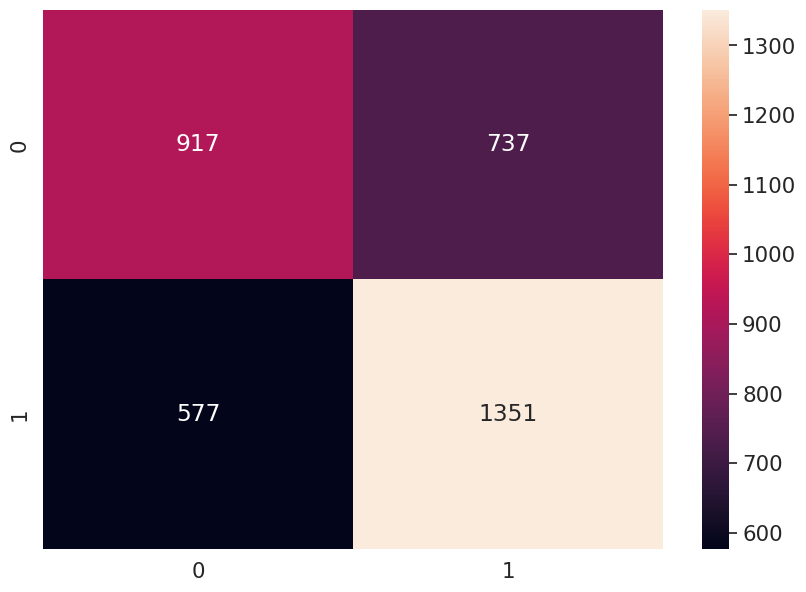

In [71]:
## EXTRA: Confusion Matrix
cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [72]:
#### End of Model ####


# Formatting Final Results

final_results = pd.concat([y_test, users], axis = 1).dropna()

In [73]:
final_results['predictions'] = y_pred

In [74]:
final_results = final_results[['entry_id', 'e_signed', 'predictions']]

In [75]:
final_results

,entry_id,e_signed,predictions
3629,8825262,1.0,0
1820,9216889,1.0,0
6685,1762129,0.0,0
17241,7249770,1.0,1
8332,5967375,1.0,1
...,...,...,...
7546,9384491,1.0,1
9836,2445124,1.0,0
7446,6534419,1.0,1
9526,5501730,1.0,0
